In [45]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

from tensorflow import keras
from keras.optimizers import Adam
from keras.layers import Input, Embedding, Flatten, dot, Dense, Concatenate
from keras.models import Model
import random

**Part I: ML Method for Recommendations**

In [2]:
movies = pd.read_csv('movies.csv', usecols=['movieId','title'])

In [3]:
ratings=pd.read_csv('ratings.csv',usecols=['userId', 'movieId', 'rating'])

In [4]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [5]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
dataset = pd.merge(ratings,movies,on='movieId')

In [7]:
dataset.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [8]:
combined_df = dataset.dropna(axis=0)

In [9]:
combined_df['totalRating']=''

In [10]:
combined_df.head()

,userId,movieId,rating,title,totalRating
0,1,1,4.0,Toy Story (1995),
1,5,1,4.0,Toy Story (1995),
2,7,1,4.5,Toy Story (1995),
3,15,1,2.5,Toy Story (1995),
4,17,1,4.5,Toy Story (1995),


In [11]:
uniq = combined_df['movieId'].unique()

In [12]:
uniq = list(uniq)

In [13]:
totalRating = []

In [17]:
for i in uniq:
  sum = combined_df.query("movieId == " + str(i))['rating'].sum()
  totalRating.append(sum)

In [18]:
for i in range(len(combined_df)):
  idx = uniq.index(combined_df['movieId'][i])
  sum = totalRating[idx]
  combined_df['totalRating'][i] = sum

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [19]:
combined_df = combined_df[combined_df['totalRating'] > 200]

In [20]:
combined_df.tail()

,userId,movieId,rating,title,totalRating
79246,603,1997,4.0,"Exorcist, The (1973)",201.5
79247,606,1997,3.0,"Exorcist, The (1973)",201.5
79248,607,1997,5.0,"Exorcist, The (1973)",201.5
79249,608,1997,4.5,"Exorcist, The (1973)",201.5
79250,610,1997,4.0,"Exorcist, The (1973)",201.5


In [21]:
movie_features_df = combined_df.pivot_table(index='title',columns='userId',values='rating').fillna(0)

In [22]:
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,570,571,572,573,574,575,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12 Angry Men (1957),0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001: A Space Odyssey (1968),0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,4.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,4.5
28 Days Later (2002),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,3.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,5.0
300 (2007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,3.5,0.0,0.0,4.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,4.0
"40-Year-Old Virgin, The (2005)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,2.5,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5


In [24]:
movie_matrix = csr_matrix(movie_features_df.values)

In [25]:
model_nn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_nn.fit(movie_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [150]:
def giveRecommendation(idx):
  distances, indices = model_nn.kneighbors(movie_features_df.iloc[idx,:].values.reshape(1, -1), n_neighbors = 6)
  for i in range(len(distances.flatten())):
    if i == 0:
        print('Recommendations for a User Based on the Movie he /she Liked for {0}:\n'.format(movie_features_df.index[idx]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Nearest Neighbour Method for Recommending Movies

We are using Nearest Neighbour method to recommend users. We have combined the two datasets movies.csv and ratings.csv and found out the total rating for each movie. We have also used a threshold where we will be recommending movies whose total rating is above 200. Further we creating a pivot matrix, where on the columns we have userids and on indices we have movies. Here the userids are our features. The pivot matrix is important for cosine similarity. Then we have used Sklearns nearest neighbor to recommend movies.The output of this models is distances and indices, where distance is the distance from the original movie.

Recommendation for New User

> If there is new user we can recommend him movies based on two criterias. The first one is randomly recommend him movies and the other one is based on the timestamp of the last user and random user and suggesting him movies which are popular with his timestamp. We are following this method because we do not know what type of movies are new user likes



In [152]:
new_user_random = np.random.choice(movie_features_df.shape[0])
giveRecommendation(new_user_random)

Recommendations for a User Based on the Movie he /she Liked for Speed (1994):

1: True Lies (1994), with distance of 0.32717986563027057:
2: Jurassic Park (1993), with distance of 0.33826798970287697:
3: Fugitive, The (1993), with distance of 0.3515247256589241:
4: Die Hard: With a Vengeance (1995), with distance of 0.36591259007105126:
5: Terminator 2: Judgment Day (1991), with distance of 0.3699075363774109:


Recommendation for Existing User

In [153]:
existing_user_id=603

In [154]:
giveRecommendation(combined_df['userId'][603])

Recommendations for a User Based on the Movie he /she Liked for Christmas Story, A (1983):

1: Ferris Bueller's Day Off (1986), with distance of 0.44127665387008297:
2: Breakfast Club, The (1985), with distance of 0.4488133281806057:
3: Big (1988), with distance of 0.4941967288985074:
4: Wizard of Oz, The (1939), with distance of 0.5035215816307477:
5: Who Framed Roger Rabbit? (1988), with distance of 0.5048818199065459:


Part II: Deep Learning Methods for Recommendations

In [135]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [89]:
ratings=pd.read_csv('ratings.csv')

In [122]:
movies = pd.read_csv('movies.csv', usecols=['movieId','title'])

In [91]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [123]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [95]:
ratings.userId = ratings.userId.astype('category').cat.codes.values
ratings.movieId = ratings.movieId.astype('category').cat.codes.values

In [97]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

In [98]:
uniq_users = len(ratings.userId.unique())
uniq_movies = len(ratings.movieId.unique())

In [130]:
def recommend1(user_id, number_of_movies=10):
  movies = user_embedding_learnt1[user_id]@movie_embedding_learnt1.T
  mids = np.argpartition(movies, -number_of_movies)[-number_of_movies:]
  return mids

In [102]:
def createEmbeddings(name1,embName,uniq_input):
  item_input =  Input(shape=[1],name=name1)
  item_embedding = Embedding(uniq_input + 1, 20, name=embName)(item_input)
  item_vec = Flatten(name='Flatten'+name1)(item_embedding)
  return item_input,item_embedding,item_vec


In [103]:
movie_input,movie_embedding,movie_vec = createEmbeddings('movie','movie-embedding',uniq_movies)

In [104]:
user_input,user_embedding,user_vec = createEmbeddings('user','user-embedding',uniq_users)

In [137]:
conc = Concatenate()([movie_vec, user_vec])
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(64, activation='relu')(fc1)
fc3 = Dense(32, activation='relu')(fc2)
out = Dense(1)(fc3)

model2 = Model([user_input, movie_input], out)
model2.compile('adam', 'mean_squared_error')

In [138]:
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding (Embedding)     (None, 1, 20)        194500      movie[0][0]                      
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 20)        12220       user[0][0]                       
_______________________________________________________________________________________

In [106]:
history = model2.fit([train.userId, train.movieId], train.rating, epochs=10, verbose=1)

Epoch 1/10
2521/2521 [==============================] - 10s 4ms/step - loss: 0.9966
Epoch 2/10
2521/2521 [==============================] - 10s 4ms/step - loss: 0.7073
Epoch 3/10
2521/2521 [==============================] - 10s 4ms/step - loss: 0.6617
Epoch 4/10
2521/2521 [==============================] - 10s 4ms/step - loss: 0.6276
Epoch 5/10
2521/2521 [==============================] - 10s 4ms/step - loss: 0.5926
Epoch 6/10
2521/2521 [==============================] - 10s 4ms/step - loss: 0.5607
Epoch 7/10
2521/2521 [==============================] - 11s 4ms/step - loss: 0.5295
Epoch 8/10
2521/2521 [==============================] - 10s 4ms/step - loss: 0.4953
Epoch 9/10
2521/2521 [==============================] - 10s 4ms/step - loss: 0.4607
Epoch 10/10
2521/2521 [==============================] - 10s 4ms/step - loss: 0.4262


Text(0, 0.5, 'Training Error')

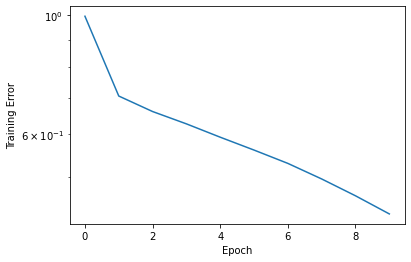

In [136]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [131]:
movie_embedding_learnt1 = model2.get_layer(name='movie-embedding').get_weights()[0]
user_embedding_learnt1 = model2.get_layer(name='user-embedding').get_weights()[0]

In [139]:
rec = (recommend1(user_id=603)).tolist()

In [140]:
for i in rec:
  for j in range(len(movies)):
    if (movies['movieId'][j] == i):
      print("Movie Recommended is :",movies['title'][i])

Movie Recommended is : Moustache, La (2005)
Movie Recommended is : The Scorpion King (2002)
Movie Recommended is : Shanghai Surprise (1986)
Movie Recommended is : Garfield: The Movie (2004)
Movie Recommended is : Hope and Glory (1987)
Movie Recommended is : Black Rain (1989)
Movie Recommended is : Kazaam (1996)


Observations:
This example demonstrates using the Movielens dataset to recommend movies to users. The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies.  To recommend top n items to a user ui is simple now.
Here we are using recommender system with matrix factorization using Keras
 We take the embedding vector of the user and do a dot product with all the embedding vectors of movies and get the top n largest values. The following code returns the top 5 most relevant movie ids.

Sources:
1) https://www.youtube.com/watch?v=kccT0FVK6OY

---
2) https://petamind.com/build-a-simple-recommender-system-with-matrix-factorization/


---
3) https://youtu.be/4vwNkHFuZBk


---

4) https://keras.io/examples/structured_data/collaborative_filtering_movielens/



---
5) https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929

